# Signal diagnostics with an ensemble of DL models
Here we explore probabilistic classification using multiple deep learning models

In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from scipy.stats import norm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

from sklearn.metrics import accuracy_score

## Create a data model
For this tutorial we'll use synthetic data. We'll have two types of signal states which can both be present or not present.

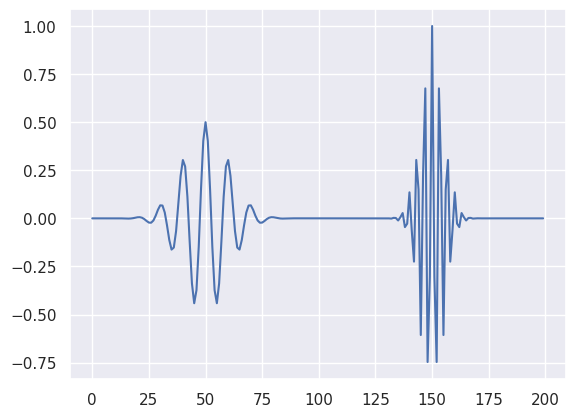

In [2]:
def create_signal(a_amp=0.5, a_freq=1, a_sigma=1, a_shift=5,
                  b_amp=1, b_freq=3, b_sigma=0.5, b_shift=-5,
                  noise_amp=0, x_lims=10):

    x = np.arange(-x_lims, x_lims, 0.1)
    a_signal = np.exp(2j * np.pi * a_freq * (x+a_shift)) * np.exp(-(x+a_shift)**2 / (2 * a_sigma**2))
    a_signal = a_signal.real
    a_signal = a_amp * a_signal

    b_signal = np.exp(2j * np.pi * b_freq * (x+b_shift)) * np.exp(-(x+b_shift)**2 / (2 * b_sigma**2))
    b_signal = b_signal.real
    b_signal = b_amp * b_signal

    noise = np.random.randn(len(x)) * noise_amp / 5
    
    signal = a_signal + b_signal + noise
    
    return signal

plt.plot(create_signal())
plt.show()

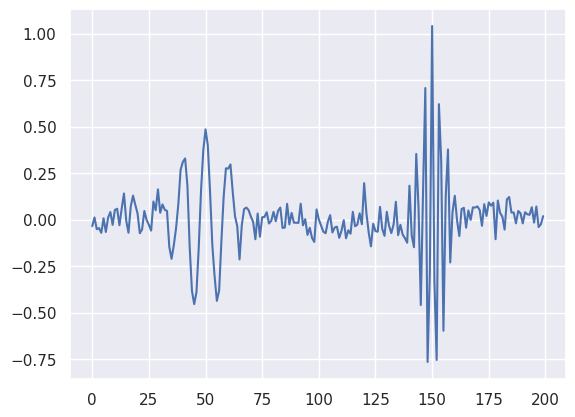

In [20]:
plt.plot(create_signal(noise_amp=0.3))
plt.show()

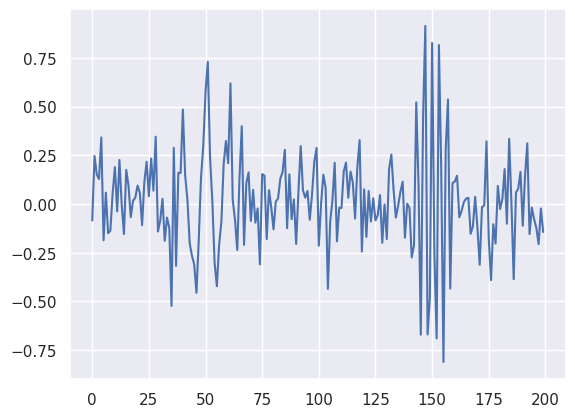

In [19]:
plt.plot(create_signal(noise_amp=0.8))
plt.show()

## Test on a deterministic model

In [5]:
def create_dataset(signal_amp_range=(0.25,1), shift_range=(-5,5), noise_range=(0,0.1), n_training_obs = 50000):                       
    
    # Create targets
    np.random.seed(2049)
    a_targets = np.random.choice([0,1], size=n_training_obs)
    b_targets = np.random.choice([0,1], size=n_training_obs)
    targets = np.array(list(zip(a_targets,b_targets)))
    
    # Create features
    a_amp_list = np.random.rand(n_training_obs)*(signal_amp_range[1] - signal_amp_range[0]) + signal_amp_range[0]
    a_shift_list = np.random.rand(n_training_obs)*(shift_range[1] - shift_range[0]) + shift_range[0]
    
    b_amp_list = np.random.rand(n_training_obs)*(signal_amp_range[1] - signal_amp_range[0]) + signal_amp_range[0]
    b_shift_list = np.random.rand(n_training_obs)*(shift_range[1] - shift_range[0]) + shift_range[0]
    
    # Turn the signal on or off based on their target state
    a_amp_list = a_amp_list * a_targets
    b_amp_list = b_amp_list * b_targets
    
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]
    signal_params = np.array(list(zip(a_amp_list, a_shift_list, b_amp_list, b_shift_list, noise_list)))
    features = np.array([create_signal(a_amp=a_amp,a_shift=a_shift,b_amp=b_amp,b_shift=b_shift,noise_amp=noise) for a_amp, a_shift, b_amp, b_shift, noise in signal_params])
    
    # reshape the features for a 1D convo layer: (# Obs, # steps, # channels)
    features = features.reshape(features.shape[0],features.shape[1],1)

    return features, targets, noise_list

In [39]:
features, targets, noise_list = create_dataset(noise_range=(0.3, 0.8), n_training_obs = 10000)

X_train, X_test, y_train, y_test, noise_train, noise_test = train_test_split(features, targets, noise_list, test_size=0.5, random_state=2049)

[1 1]


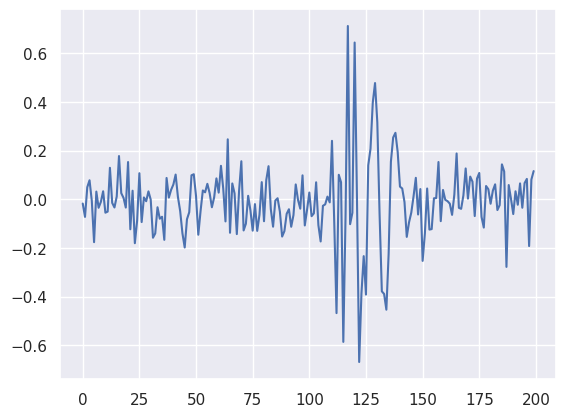

In [40]:
def plot_feature_target_pair(idx):
    print(targets[idx])
    plt.plot(features[idx])
    plt.show()

plot_feature_target_pair(112)

In [41]:
def create_model(input_shape=(200, 1), output_shape=2):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(output_shape, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

m = create_model()
m.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_166 (Conv1D)          (None, 200, 64)           256       
_________________________________________________________________
max_pooling1d_166 (MaxPoolin (None, 100, 64)           0         
_________________________________________________________________
conv1d_167 (Conv1D)          (None, 100, 32)           6176      
_________________________________________________________________
max_pooling1d_167 (MaxPoolin (None, 50, 32)            0         
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 50, 16)            1552      
_________________________________________________________________
max_pooling1d_168 (MaxPoolin (None, 25, 16)            0         
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 25, 16)          

In [42]:
clf = create_model()
history = clf.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
157/157 [==============================] - 1s 6ms/step - loss: 0.4157 - accuracy: 0.5128
Epoch 2/10
157/157 [==============================] - 1s 5ms/step - loss: 0.1005 - accuracy: 0.7254
Epoch 3/10
157/157 [==============================] - 1s 5ms/step - loss: 0.0805 - accuracy: 0.6962
Epoch 4/10
157/157 [==============================] - 1s 5ms/step - loss: 0.0684 - accuracy: 0.6744
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0608 - accuracy: 0.6666
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0612 - accuracy: 0.6722
Epoch 7/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0508 - accuracy: 0.6564
Epoch 8/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0511 - accuracy: 0.6532
Epoch 9/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0462 - accuracy: 0.6534
Epoch 10/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0439 - accuracy: 0.6510

In [43]:
# Get predictions
y_pred = (clf.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Calculate accuracy per label
label_accuracies = [accuracy_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
overall_accuracy = np.mean(label_accuracies)

print("Label-wise Accuracy:", label_accuracies)
print("Overall Average Accuracy:", overall_accuracy)

Label-wise Accuracy: [0.9904, 0.9754]
Overall Average Accuracy: 0.9829


## Train an ensemble model

In [44]:
n_models = 100
n_training_obs = 5000
models = []
np.random.seed(2049)

for n in tqdm(range(n_models)):

    features, targets, noise_list = create_dataset(noise_range=(0.3, 0.8), n_training_obs=n_training_obs)
    clf = create_model()
    history = clf.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    models.append(clf)

print('Done')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [15:40<00:00,  9.40s/it]

Done


In [47]:
X_test, y_test, noise_test = create_dataset(noise_range=(0.3, 0.8), n_training_obs = 5000)

y_pred = []

for model in tqdm(models):
    result = model.predict(features)
    y_pred.append(result)

y_pred = np.array(y_pred)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.15it/s]


In [57]:
a_pred = y_pred[:,:,0].T
a_mean = a_pred.mean(axis=1)
a_class = a_mean.round()
a_std = a_pred.std(axis=1)

b_pred = y_pred[:,:,1].T
b_mean = b_pred.mean(axis=1)
b_class = b_mean.round()
b_std = b_pred.std(axis=1)

In [67]:
a_error = np.abs(a_mean - y_test[:,0])
b_error = np.abs(b_mean - y_test[:,1])

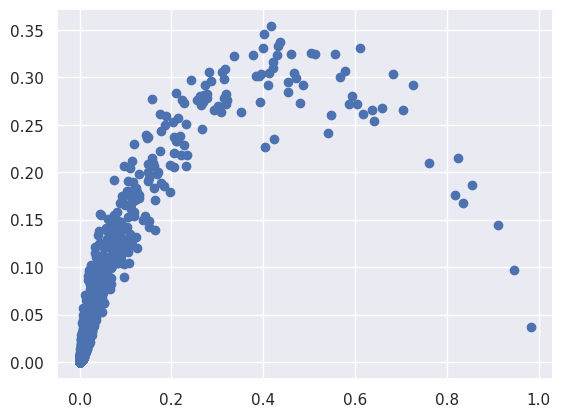

In [68]:
plt.scatter(a_error, a_std)
plt.show()

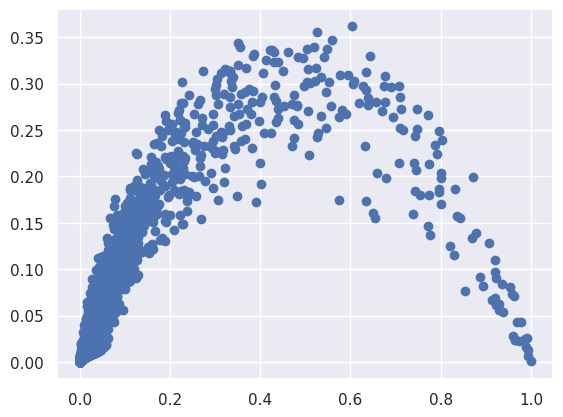

In [69]:
plt.scatter(b_error, b_std)
plt.show()

In [73]:
X_test, y_test, noise_test = create_dataset(noise_range=(1, 2), n_training_obs = 5000)

y_pred = []

for model in tqdm(models):
    result = model.predict(features)
    y_pred.append(result)

y_pred = np.array(y_pred)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]


In [78]:
a_pred = y_pred[:,:,0].T
a_mean = a_pred.mean(axis=1)
a_class = a_mean.round()
a_std = a_pred.std(axis=1)

b_pred = y_pred[:,:,1].T
b_mean = b_pred.mean(axis=1)
b_class = b_mean.round()
b_std = b_pred.std(axis=1)

a_error = np.abs(a_mean - y_test[:,0])
b_error = np.abs(b_mean - y_test[:,1])

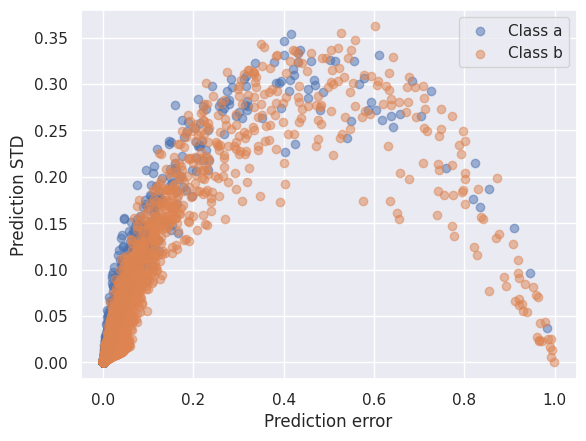

In [92]:
plt.scatter(a_error, a_std, alpha=0.5, label='Class a')
plt.scatter(b_error, b_std, alpha=0.5, label='Class b')
plt.xlabel('Prediction error')
plt.ylabel('Prediction STD')
plt.legend()
plt.show()

True: [1 1]
Pred: [1.0 0.9999949932098389]


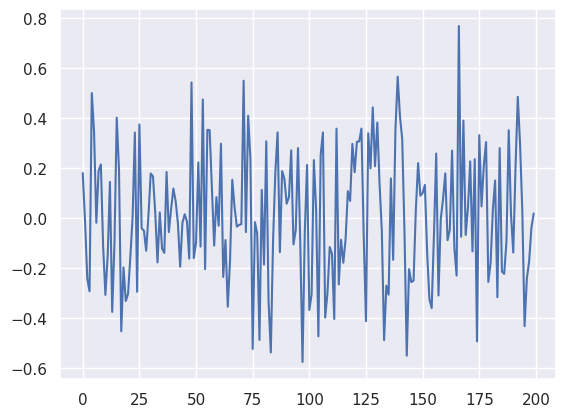

In [83]:
def plot_feature_target_pair(idx):
    print('True:', y_test[idx])
    print('Pred: [{} {}]'.format(a_mean[idx], b_mean[idx])) 
    plt.plot(X_test[idx])
    plt.show()

plot_feature_target_pair(10)